In [386]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tslearn.metrics import dtw_path

from DILATE.loss.dilate_loss import dilate_loss
from DILATE.models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU

from scipy.spatial.distance import directed_hausdorff

In [369]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading dataset

In [92]:
# Lire le fichier .gz en tant que DataFrame
with gzip.open('Traffic/traffic.txt.gz', 'rt') as f:
    df = pd.read_csv(f, header=None)

# Extraire la première colonne
time_series = df.iloc[:, 0].values

# Afficher le résultat
print("Shape de la série temporelle :", time_series.shape)
print("Quelques valeurs :", time_series[:10])

Shape de la série temporelle : (17544,)
Quelques valeurs : [0.0048 0.0072 0.004  0.0039 0.0042 0.004  0.0044 0.0042 0.0086 0.0223]


# Splitting dataset

In [93]:
# Paramètres de la configuration
input_length = 168  # Points passés (1 semaine)
output_length = 24  # Points futurs (24 heures)
train_split = 0.6
valid_split = 0.2

# Taille totale de la série
n_points = len(time_series)

# Indices pour la séparation train/valid/test
train_end = int(train_split * n_points)
valid_end = int((train_split + valid_split) * n_points)

# Création des fenêtres glissantes pour chaque ensemble
def create_windows(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length])
        y.append(data[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)

# Entraînement
train_data = time_series[:train_end]
X_train, y_train = create_windows(train_data, input_length, output_length)

# Validation
valid_data = time_series[train_end:valid_end]
X_valid, y_valid = create_windows(valid_data, input_length, output_length)

# Test
test_data = time_series[valid_end:]
X_test, y_test = create_windows(test_data, input_length, output_length)

# Affichage des tailles des ensembles
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (10335, 168) (10335, 24)
Valid: (3318, 168) (3318, 24)
Test: (3318, 168) (3318, 24)


# Plotting dataset

# Training

In [218]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).unsqueeze(-1)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=batch_size, drop_last=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, drop_last=True)

In [278]:
def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs): 
        for i, data in enumerate(train_loader, 0):
            inputs, target = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)
            batch_size, N_output = target.shape[0:2]                     

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)             
                  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
        
        if(verbose):
            print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
            eval_model(net,valid_loader, gamma,verbose=1)

    net.eval()
  

def eval_model(net,loader, gamma, verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
            loss_dtw += sim
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean())

## Training models

In [319]:
n_epochs = 5
lr = 0.001
gamma = 0.001
alpha = 0.5

output_size = 24

In [320]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse = Net_GRU(encoder, decoder, output_size, device)

In [321]:
train_model(net=net_gru_mse, loss_type="mse", learning_rate=lr, epochs=n_epochs, verbose=True, gamma=gamma, alpha=alpha)

epoch  0  loss  0.0029918255750089884  loss shape  0  loss temporal  0
 Eval mse=  0.002505587263822592  dtw=  0.2015264301730972  tdi=  2.977852349707245
epoch  1  loss  0.0020076585933566093  loss shape  0  loss temporal  0
 Eval mse=  0.0016022013690363726  dtw=  0.1288154157648514  tdi=  0.42631314678649235
epoch  2  loss  0.0016404647612944245  loss shape  0  loss temporal  0
 Eval mse=  0.001202251798674172  dtw=  0.11477752788742453  tdi=  0.2499324491081154
epoch  3  loss  0.0017500492976978421  loss shape  0  loss temporal  0
 Eval mse=  0.0012976655761674776  dtw=  0.12030358201690819  tdi=  0.28479775156590414
epoch  4  loss  0.0017818097257986665  loss shape  0  loss temporal  0
 Eval mse=  0.0010737648120209319  dtw=  0.10378963483042174  tdi=  0.23557283156318085


In [322]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder, decoder, output_size, device)

In [323]:
train_model(net=net_gru_dilate, loss_type="dilate", learning_rate=0.001, epochs=n_epochs, verbose=True, gamma=gamma, alpha=alpha)

epoch  0  loss  0.19041500985622406  loss shape  0.3293432891368866  loss temporal  0.051486726850271225
 Eval mse=  0.012490887998365889  dtw=  0.5367931479513112  tdi=  3.723277505446623e-06
epoch  1  loss  0.2007361799478531  loss shape  0.3561868369579315  loss temporal  0.045285530388355255
 Eval mse=  0.012056025174245531  dtw=  0.5271190360540629  tdi=  0.0
epoch  2  loss  0.1810358613729477  loss shape  0.2745157778263092  loss temporal  0.08755595237016678
 Eval mse=  0.0098208008041861  dtw=  0.47165708422827224  tdi=  0.011707048270697169
epoch  3  loss  0.19347435235977173  loss shape  0.32246699929237366  loss temporal  0.0644817054271698
 Eval mse=  0.011017718818038702  dtw=  0.5018838151292917  tdi=  0.002146203533496732
epoch  4  loss  0.17959930002689362  loss shape  0.3009878098964691  loss temporal  0.058210790157318115
 Eval mse=  0.011062629091754263  dtw=  0.5039659261175222  tdi=  0.0004010501770152505


# Visualizing and evaluating results

In [344]:
def plot_preds(X_train, y_train, preds):
    """
    Trace les valeurs d'entraînement, les valeurs réelles et les prédictions.

    Args:
        X_train (array-like): Les données passées (d'entraînement).
        y_train (array-like): Les valeurs réelles futures.
        y_preds (array-like): Les prédictions principales.
        other_preds (dict, optional): Dictionnaire de séries de prédictions supplémentaires.
                                      Exemple: {"Modèle 1": array, "Modèle 2": array}.
    """
    plt.figure(figsize=(24, 12))
    
    # Trace des valeurs d'entraînement
    plt.plot(range(len(X_train)), X_train, label="Valeurs passées", color="blue")
    
    # Trace des valeurs réelles
    plt.plot(range(len(X_train), len(X_train) + len(y_train)), y_train, label="Valeurs réelles", color="green")
    
    # Trace des prédictions supplémentaires (si fournies)
    for name, predictions in preds.items():
        plt.plot(range(len(X_train), len(X_train) + len(predictions)), predictions, label=f"Valeurs prédites ({name})", linestyle="--")
    
    # Ajouter une ligne verticale pour séparer passé et futur
    plt.axvline(x=len(X_train), color="black", linestyle=":", label="Début des prédictions")
    
    # Configurations du graphique
    plt.title("Exemple de Série Temporelle (Train, Réel, Prédictions)")
    plt.xlabel("Temps (indices)")
    plt.ylabel("Valeurs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [345]:
gen_test = iter(test_loader)
test_inputs, test_targets = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)

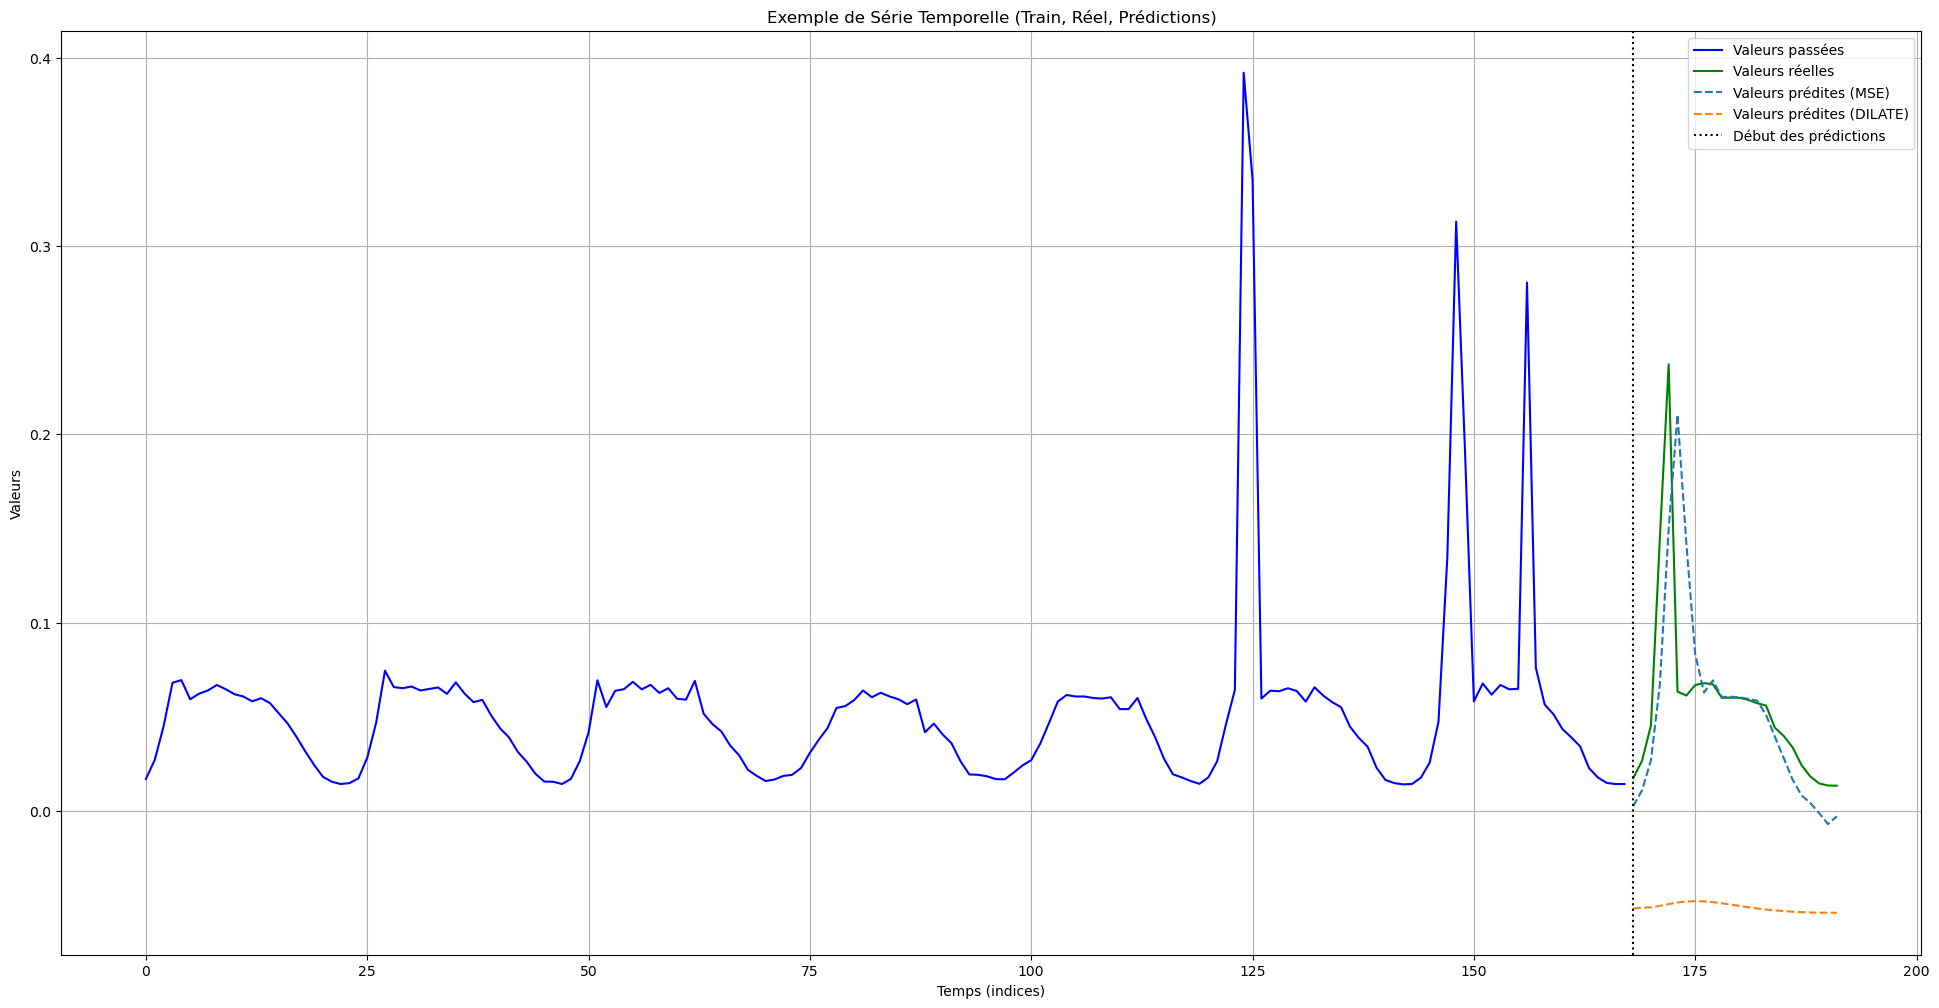

In [346]:
ind_to_plot = 55

nets = [net_gru_mse, net_gru_dilate]
preds_mse = net_gru_mse(test_inputs)[ind_to_plot,:,:].squeeze(-1).detach().numpy()
preds_dilate = net_gru_dilate(test_inputs)[ind_to_plot,:,:].squeeze(-1).detach().numpy()

preds = {"MSE": preds_mse, "DILATE": preds_dilate}

X_true = test_inputs[ind_to_plot,:,:].squeeze(-1)
y_true = test_targets[ind_to_plot,:,:].squeeze(-1)

plot_preds(X_true, y_true, preds)

In [347]:
eval_model(net_gru_mse, test_loader, gamma)

 Eval mse=  0.0023851867202514163  dtw=  0.16350852174643685  tdi=  0.2563253165849673


In [348]:
eval_model(net_gru_dilate, test_loader, gamma)

 Eval mse=  0.015588770492696295  dtw=  0.5869989688191071  tdi=  0.0044961235362200435


## Non differentiable scores

In [393]:
def hausdorff_distance(true_series, predicted_series):
    A = np.array(true_series).reshape(-1, 1)
    B = np.array(predicted_series).reshape(-1, 1)
    
    forward_distance = directed_hausdorff(A, B)[0]
    backward_distance = directed_hausdorff(B, A)[0]
    
    return max(forward_distance, backward_distance)


def swinging_doors(data, epsilon):
    SD_ts = np.zeros_like(data)
    lower_slope = +np.inf
    upper_slope = -np.inf
    start_idx = 0

    for i in range(1, len(data)):
        lower_slope = min(lower_slope, (data[i] - (data[start_idx] - epsilon)) / (i - start_idx))
        upper_slope = max(upper_slope, (data[i] - (data[start_idx] + epsilon)) / (i - start_idx))

        if lower_slope < upper_slope or i==len(data)-1:
            current_slope = (data[i] - data[start_idx]) / (i - start_idx)
            SD_ts[start_idx:i] = np.array([current_slope*j+data[start_idx] for j in range(i-start_idx)])
            start_idx = i      
            lower_slope = +np.inf
            upper_slope = -np.inf
    SD_ts[-1] = data[-1]
    return SD_ts


def mae(ramp_approx_1, ramp_approx_2):
    return np.mean(np.abs(ramp_approx_1-ramp_approx_2))


def ramp_score(true_series, predicted_series, epsilon):
    ramp_approx_1 = swinging_doors(true_series, epsilon)
    ramp_approx_2 = swinging_doors(predicted_series, epsilon)
    return mae(ramp_approx_1, ramp_approx_2)

In [395]:
hd_mse = hausdorff_distance(true_series=y_true, predicted_series=preds["MSE"])
hd_dilate = hausdorff_distance(true_series=y_true, predicted_series=preds["DILATE"])

ramp_mse = ramp_score(true_series=y_true, predicted_series=preds["MSE"], epsilon=0.01)
ramp_dilate = ramp_score(true_series=y_true, predicted_series=preds["DILATE"], epsilon=0.01)

print("Hausdorff distances:")
print("MSE:", hd_mse)
print("DILATE:", hd_dilate)
print("\n")
print("Ramp scores:")
print("MSE:", ramp_mse)
print("DILATE:", ramp_dilate)

Hausdorff distances:
MSE: 0.026793286204338074
DILATE: 0.285225585103035


Ramp scores:
MSE: 0.019709548
DILATE: 0.10113046
